In [1]:
#기본 패키지
import time
import warnings
warnings.filterwarnings('ignore')

#데이터 처리 패키지
import numpy as np
import pandas as pd

#시각화 패키지
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user
from matplotlib import rc 
rc('font', family='malgun gothic')
rc('axes', unicode_minus = False)
import seaborn as sns
#plt.style.use('ggplot')

#수학 패키지
from scipy.stats.mstats import gmean
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import uuid
import random
from tqdm import tqdm, tqdm_notebook
from itertools import combinations

#머신러닝 패키지
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import *
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.linear_model import BayesianRidge
from vecstack import stacking, StackingTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse

#딥러닝 패키지
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import * #Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
#from keras.utils.np_utils import *
#from tensorflow.keras.utils.vis_utils import * #model_to_dot
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import *
from tensorflow.keras import layers
print('tf Version \n', tf.__version__)
print('tf.keras Version \n', tf.keras.__version__)

import kerastuner as kt
import datetime
import os
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

import shap

import klib
# Dacon plotly 그림 업로드 
pd.options.plotting.backend = 'plotly'
## plotly.io를 import 한 후 renderers 기본값을 꼭 "notebook_connected" 로 설정해주시기 바랍니다.
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

tf Version 
 2.3.0
tf.keras Version 
 2.4.0


In [2]:
cus = pd.read_csv("open/cus_info.csv")
hist = pd.read_csv("open/stk_bnc_hist.csv")
iem = pd.read_csv("open/iem_info.csv")
train = pd.read_csv("open/stk_hld_train.csv")
test = pd.read_csv("open/stk_hld_test.csv")

submission = pd.read_csv("open/sample_submission.csv")

## 1. cus(10,000건): 고객 및 주거래계좌 정보

- act_id: 계좌 ID
- sex_dit_cd: 성별
- cus_age_stn_cd: 연령대
- ivs_icn_cd: 투자성향
- cus_aet_stn_cd: 자산구간
- mrz_pdt_tp_sgm_cd: 주거래상품군
- lsg_sgm_cd: Life Style
- tco_cus_grd_cd: 서비스 등급
- tot_ivs_te_sgm_cd: 총 투자기간
- mrz_btp_dit_cd: 주거래업종구분

In [3]:
cus.columns=['계좌번호','성별','연령대','투자성향','자산구간','주거래상품군','Life_style','서비스등급','총투자기간','주거래업종구분']
hist.columns=['계좌번호','기준일자','종목코드','잔고수량','잔고금액','주당액면가']
iem.columns=['종목코드','종목한글명','종목업종','시가총액규모유형','시장구분']
train.columns=['계좌번호','종목코드','매수일자','hold_d']
test.columns=['계좌번호','종목코드','매수일자','과거보유일','submit_id','hold_d']

hold_d에 0.6을 곱한 값을 과거보유일로 했을 때 영향력이 아주 강했다.\
타겟값을 그대로 사용하였을 때 이러한 결과가 나왔기 때문에 카테고리별로 이러한 값을 넣어주어도 과적합이 일어나지 않을 것으로 보인다.

- 우리가 예측해야하는 값이 뭐냐? - 바로 2020년 12월 31일 이후 살아있는 주식들이 얼마나 보유될 것인가를 예측해야한다.

지금 우리에게 있는 데이터는 train 과 test 데이터가 있다.\
train 데이터에는 16년부터 20년 12월30일까지 종료된, 한마디로 팔아버린 주식에 대한 데이터가 있다.\
test 에는 20년 12월30일 이전 구매한 주식을 아직 가지고 있는 데이터가 있다.\
train에는 16년에 사고 16년에 판 주식도 있을 것이고 16년에 사고 20년 12월에 판 주식도 있을 것이다.

### 과거보유일을 어떻게 넣어줄 것인가가 중요한 것이다!!!

16 년 12월 30일을 기준으로 잘라서 데이터 생성(과거보유일, hold_d 가능)\
17 년 12월 30일을 기준으로 잘라서 데이터 생성(과거보유일, hold_d 가능)\
18 년 12월 30일을 기준으로 잘라서 데이터 생성(과거보유일, hold_d 가능)\
19 년 12월 30일을 기준으로 잘라서 데이터 생성(과거보유일, hold_d 가능)

20 년 12월 30일을 기준으로 잘라서 데이터 --> test_data

In [4]:
hist['기준일자']=pd.to_datetime(hist.기준일자.astype(str))
train['매수일자']=pd.to_datetime(train.매수일자.astype(str))
test['매수일자']=pd.to_datetime(test.매수일자.astype(str))

In [5]:
# diff 를 하기 위해 순서대로 정렬해준 것
hist_order=hist.sort_values(by=['계좌번호','종목코드','기준일자'],ascending=True).reset_index(drop='index')

고객이 특정 종목을 여러번 시작했을 경우 밑의 전처리에서 계좌번호와 종목코드로만 묶을 경우 해소되지 않는 부분을 해소하기 위한 방법

In [6]:
train_t=train.reset_index()
train_t.columns=['종류별', '계좌번호', '종목코드', '매수일자', 'hold_d']
train_t.종류별=train_t.종류별+1

In [7]:
test_t=test.reset_index()
test_t.columns=['종류별', '계좌번호', '종목코드', '매수일자', '과거보유일', 'submit_id', 'hold_d']
test_t.drop(['과거보유일','submit_id'],axis=1,inplace=True)

In [8]:
test_t.종류별=test_t.종류별+681473

In [9]:
tt=pd.concat((train_t,test_t)).reset_index(drop=True)

In [10]:
hist_order=pd.merge(hist_order,tt[['계좌번호','종목코드','매수일자','종류별']],how='left',left_on=['계좌번호','종목코드','기준일자'],right_on=['계좌번호','종목코드','매수일자'])
hist_order.drop('매수일자',axis=1,inplace=True)

In [11]:
hist_order['종류별']=hist_order.종류별.fillna(method='pad')
hist=pd.merge(hist,hist_order[['계좌번호','기준일자','종목코드','종류별']],how='left',on=['계좌번호','기준일자','종목코드'])

In [12]:
hist.drop(['잔고수량','잔고금액','주당액면가'],axis=1,inplace=True)

In [13]:
hist

,계좌번호,기준일자,종목코드,종류별
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2020-08-20,A008770,681511.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2020-06-23,A008770,681511.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2016-01-04,A005940,681510.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2020-08-14,A005930,681509.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2020-06-23,A005930,681509.0
...,...,...,...,...
2573834,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2020-08-06,A035720,680918.0
2573835,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2020-08-13,A035720,680918.0
2573836,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2020-08-19,A035720,680917.0
2573837,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2020-08-25,A035720,680917.0


In [97]:
test_t.매수일자='2020-12-31'

In [100]:
hist=pd.concat((hist,test_t[['계좌번호','매수일자','종목코드','종류별']]))

In [35]:
train
# 과거보유일이 주식보유기간과 어떤 관련이 있는지 과거보유일에 대한 피처를 만들 때 근거있는 식을 만들기

,계좌번호,종목코드,매수일자,hold_d,과거보유일
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,6.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,48.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,3.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,13.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,194.0
...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,20180831,1,0.0
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A271980,20201027,1,0.0
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,20181121,1,0.0
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,20200214,1,0.0


In [69]:
train["과거보유일"] = train["hold_d"]*0.6
train.과거보유일 = np.trunc(train["과거보유일"])

In [362]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data = pd.merge(train, cus, how = "left", on = ["계좌번호"])
train_data = pd.merge(train_data, iem, how = "left", on = ["종목코드"])

test_data = pd.merge(test, cus, how = "left", on = ["계좌번호"])
test_data = pd.merge(test_data, iem, how = "left", on = ["종목코드"])

In [363]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

hist["평균잔고금액"] = hist["잔고금액"] / hist["잔고수량"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", left_on = ["계좌번호", "종목코드",'매수일자'],right_on=['계좌번호','종목코드','기준일자'])
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left",  left_on= ["계좌번호", "종목코드",'매수일자'],right_on=['계좌번호','종목코드','기준일자'])
test_data.reset_index(drop = True, inplace = True)

In [325]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681472 entries, 0 to 681471
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   계좌번호        681472 non-null  object 
 1   종목코드        681472 non-null  object 
 2   매수일자        681472 non-null  int64  
 3   hold_d      681472 non-null  int64  
 4   과거보유일       681472 non-null  float64
 5   성별          681472 non-null  int64  
 6   연령대         681472 non-null  int64  
 7   투자성향        681472 non-null  int64  
 8   자산구간        681472 non-null  int64  
 9   주거래상품군      681472 non-null  int64  
 10  Life_style  681472 non-null  int64  
 11  서비스등급       681472 non-null  int64  
 12  총투자기간       681472 non-null  int64  
 13  주거래업종구분     681472 non-null  int64  
 14  종목한글명       681472 non-null  object 
 15  종목업종        681472 non-null  int64  
 16  시가총액규모유형    681472 non-null  int64  
 17  시장구분        681472 non-null  int64  
 18  기준일자        681472 non-null  int64  
 19  잔고

1. 성별 - 그대로 넣기
2. 연령 - 그대로 넣기
3. 투자성향 - 99를 0으로 바꿔주기
4. 자산구간 - 자신의 총자산 금액 구간별 코드 - 투자성향과 합쳐서 워드투백터(일단은 곱으로 해결했음)
5. 주거래상품군 - 대부분이 2(국내상품) 이다. 
6. Life_style - 나이와 성별 직종을 묶어 나타낸 것이다. 이를 오히려 나이와 성별까지 더해서 구분하면 좋을 것으로 보인다.
7. 서비스등급 - 자산구간과 역수라고 생각하면 된다.
8. 총투자기간 - hold_d와 연관성이 가장 높다고 생각한다.
9. 주거래업종구분 - 제조가 많고 mean_encoding을 해도 괜찮을 것으로 보인다.
10. 종목한글명 + 11. 종목업종 - 종목업종 별 종목 중 가장 많은 종목에 투자를 하였는지를 확인하기 위해 mode를 이용하여 사용
11. 시가총액규모유형 - 어떻게 사용해야할지 모르겠다
12. 시장구분 - 이 또한 어떻게 사용해야할지 모르겠다.

# 수치형 변수 분포확인

In [364]:
train_data['매수일자']=pd.to_datetime(train_data.매수일자.astype(str))
test_data['매수일자']=pd.to_datetime(test_data.매수일자.astype(str))

In [365]:
train_data['년']=train_data.매수일자.dt.year
train_data['월']=train_data.매수일자.dt.month
train_data['일']=train_data.매수일자.dt.day
train_data['요일']=train_data.매수일자.dt.day_of_week

test_data['년']=test_data.매수일자.dt.year
test_data['월']=test_data.매수일자.dt.month
test_data['일']=test_data.매수일자.dt.day
test_data['요일']=test_data.매수일자.dt.day_of_week

In [366]:
train_test=pd.concat([train_data,test_data])
train_test=train_test.reset_index(drop='index')

In [367]:
for i in np.arange(0.2,1,0.2):
    print(train_test.groupby('년').잔고수량.quantile(q=i))

년
2016    20.0
2017     8.0
2018     8.0
2019     6.0
2020     5.0
Name: 잔고수량, dtype: float64
년
2016    122.0
2017     30.0
2018     30.0
2019     32.0
2020     25.0
Name: 잔고수량, dtype: float64
년
2016    400.0
2017    100.0
2018    100.0
2019    110.0
2020    100.0
Name: 잔고수량, dtype: float64
년
2016    1247.6
2017     500.0
2018     400.0
2019     466.0
2020     300.0
Name: 잔고수량, dtype: float64


In [368]:
# 년도별 잔고수량 평균 이상 이하
def f_2016(x):
    if x<20:
        return 0
    elif x<122:
        return 1
    elif x<400:
        return 2
    elif x<1247:
        return 3
    else:
        return 4
def f_2017(x):
    if x<8:
        return 0
    elif x<30:
        return 1
    elif x<100:
        return 2
    elif x<500:
        return 3
    else:
        return 4
def f_2018(x):
    if x<8:
        return 0
    elif x<30:
        return 1
    elif x<100:
        return 2
    elif x<400:
        return 3
    else:
        return 4
def f_2019(x):
    if x<6:
        return 0
    elif x<32:
        return 1
    elif x<110:
        return 2
    elif x<466:
        return 3
    else:
        return 4
def f_2020(x):
    if x<5:
        return 0
    elif x<25:
        return 1
    elif x<100:
        return 2
    elif x<300:
        return 3
    else:
        return 4

In [369]:
train_data['년도_잔고수량']=0
train_data.loc[train_data.년==2016,'년도_잔고수량']=train_data.query('년==2016')['잔고수량'].apply(f_2016)
train_data.loc[train_data.년==2017,'년도_잔고수량']=train_data.query('년==2017')['잔고수량'].apply(f_2017)
train_data.loc[train_data.년==2018,'년도_잔고수량']=train_data.query('년==2018')['잔고수량'].apply(f_2018)
train_data.loc[train_data.년==2019,'년도_잔고수량']=train_data.query('년==2019')['잔고수량'].apply(f_2019)
train_data.loc[train_data.년==2020,'년도_잔고수량']=train_data.query('년==2020')['잔고수량'].apply(f_2020)

test_data['년도_잔고수량']=0
test_data.loc[test_data.년==2016,'년도_잔고수량']=test_data.query('년==2016')['잔고수량'].apply(f_2016)
test_data.loc[test_data.년==2017,'년도_잔고수량']=test_data.query('년==2017')['잔고수량'].apply(f_2017)
test_data.loc[test_data.년==2018,'년도_잔고수량']=test_data.query('년==2018')['잔고수량'].apply(f_2018)
test_data.loc[test_data.년==2019,'년도_잔고수량']=test_data.query('년==2019')['잔고수량'].apply(f_2019)
test_data.loc[test_data.년==2020,'년도_잔고수량']=test_data.query('년==2020')['잔고수량'].apply(f_2020)

---

In [370]:
train_test.groupby('년').총투자기간.mean()

년
2016    5.182650
2017    4.162498
2018    3.539667
2019    3.324126
2020    2.832396
Name: 총투자기간, dtype: float64

In [371]:
# 년도별 총투자기간 평균 이상 이하
def g_2016(x):
    if x>5.182650:
        return 1
    else:
        return 0
def g_2017(x):
    if x>4.162498:
        return 1
    else:
        return 0
def g_2018(x):
    if x>3.539667:
        return 1
    else:
        return 0
def g_2019(x):
    if x>3.324126:
        return 1
    else:
        return 0
def g_2020(x):
    if x>2.832396:
        return 1
    else:
        return 0

In [372]:
train_data['년도_총투자기간']=0
train_data.loc[train_data.년==2016,'년도_총투자기간']=train_data.query('년==2016')['총투자기간'].apply(g_2016)
train_data.loc[train_data.년==2017,'년도_총투자기간']=train_data.query('년==2017')['총투자기간'].apply(g_2017)
train_data.loc[train_data.년==2018,'년도_총투자기간']=train_data.query('년==2018')['총투자기간'].apply(g_2018)
train_data.loc[train_data.년==2019,'년도_총투자기간']=train_data.query('년==2019')['총투자기간'].apply(g_2019)
train_data.loc[train_data.년==2020,'년도_총투자기간']=train_data.query('년==2020')['총투자기간'].apply(g_2020)

test_data['년도_총투자기간']=0
test_data.loc[test_data.년==2016,'년도_총투자기간']=test_data.query('년==2016')['총투자기간'].apply(g_2016)
test_data.loc[test_data.년==2017,'년도_총투자기간']=test_data.query('년==2017')['총투자기간'].apply(g_2017)
test_data.loc[test_data.년==2018,'년도_총투자기간']=test_data.query('년==2018')['총투자기간'].apply(g_2018)
test_data.loc[test_data.년==2019,'년도_총투자기간']=test_data.query('년==2019')['총투자기간'].apply(g_2019)
test_data.loc[test_data.년==2020,'년도_총투자기간']=test_data.query('년==2020')['총투자기간'].apply(g_2020)

In [373]:
#
train_data['금액변화']=train_data.평균잔고금액-train_data.주당액면가
test_data['금액변화']=test_data.평균잔고금액-test_data.주당액면가

#
train_data['금액변화비율']=train_data.평균잔고금액/train_data.주당액면가
test_data['금액변화비율']=test_data.평균잔고금액/test_data.주당액면가

In [374]:
# 매수를 몇번 했는지
train_data=pd.merge(train_data,train_test.groupby('계좌번호')['년'].agg([('매수횟수',np.size)]).reset_index(),how='left',on='계좌번호')
test_data=pd.merge(test_data,train_test.groupby('계좌번호')['년'].agg([('매수횟수',np.size)]).reset_index(),how='left',on='계좌번호')

In [375]:
# 종목업종 별 보유기간이 어떻게 되는지 (총자산)

In [376]:
# 고객별 주 종목업종이 어떤것인지 파악을 한다.
고객_종목업종=train_test.groupby('계좌번호')['종목업종'].agg([('고객별_종목업종', lambda x: x.mode()[0])]).reset_index()

In [377]:
train_data=pd.merge(train_data,고객_종목업종,how='left',on='계좌번호')
test_data=pd.merge(test_data,고객_종목업종,how='left',on='계좌번호')

In [378]:
# 종목업종 별 hold_d 값의 평균을 넣어준 것
train_data=pd.merge(train_data,train_data.groupby('고객별_종목업종')['hold_d'].agg([('고객별_종목_hold',np.mean)]).reset_index(),how='left',on='고객별_종목업종')
test_data=pd.merge(test_data,train_data.groupby('고객별_종목업종')['hold_d'].agg([('고객별_종목_hold',np.mean)]).reset_index(),how='left',on='고객별_종목업종')

In [379]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 681472 entries, 0 to 681471
Data columns (total 33 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   계좌번호         681472 non-null  object        
 1   종목코드         681472 non-null  object        
 2   매수일자         681472 non-null  datetime64[ns]
 3   hold_d       681472 non-null  int64         
 4   성별           681472 non-null  int64         
 5   연령대          681472 non-null  int64         
 6   투자성향         681472 non-null  int64         
 7   자산구간         681472 non-null  int64         
 8   주거래상품군       681472 non-null  int64         
 9   Life_style   681472 non-null  int64         
 10  서비스등급        681472 non-null  int64         
 11  총투자기간        681472 non-null  int64         
 12  주거래업종구분      681472 non-null  int64         
 13  종목한글명        681472 non-null  object        
 14  종목업종         681472 non-null  int64         
 15  시가총액규모유형     681472 non-null  int6

In [380]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70596 entries, 0 to 70595
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   계좌번호         70596 non-null  object        
 1   종목코드         70596 non-null  object        
 2   매수일자         70596 non-null  datetime64[ns]
 3   과거보유일        70596 non-null  int64         
 4   submit_id    70596 non-null  object        
 5   hold_d       70596 non-null  int64         
 6   성별           70596 non-null  int64         
 7   연령대          70596 non-null  int64         
 8   투자성향         70596 non-null  int64         
 9   자산구간         70596 non-null  int64         
 10  주거래상품군       70596 non-null  int64         
 11  Life_style   70596 non-null  int64         
 12  서비스등급        70596 non-null  int64         
 13  총투자기간        70596 non-null  int64         
 14  주거래업종구분      70596 non-null  int64         
 15  종목한글명        70596 non-null  object        
 16  종목업종

In [143]:
train_data.groupby('투자성향')['자산구간'].mean()
# 투자성향이 전문투자가형이 자산이 상당히 높다.

투자성향
0     2.974824
1     2.079632
2     2.494175
3     2.743414
4     3.069208
5     3.557083
9     6.000000
99    2.483282
Name: 자산구간, dtype: float64

In [381]:
train_data['투자성형_자산구간']=train_data.투자성향*train_data.자산구간

test_data['투자성형_자산구간']=test_data.투자성향*test_data.자산구간

In [382]:
train_data['국내주식']=train_data.주거래상품군.apply(lambda x: 1 if x==2 else 0)

test_data['국내주식']=test_data.주거래상품군.apply(lambda x: 1 if x==2 else 0)

Life_style
- 나이와 성별 직종을 묶어 나타낸 것. 이를 오히려 나이와 성별까지 더해서 구분하면 좋을 것으로 보인다.
- Life_style 은 대체로 5이상이 hold_d가 높다

In [383]:
train_data['나이_직종']=train_data.Life_style*train_data.연령대

test_data['나이_직종']=test_data.Life_style*test_data.연령대

서비스등급
- 자산구간의 역수라고 생각

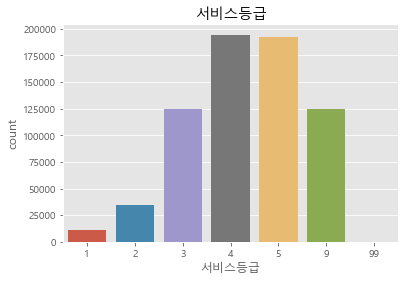

In [95]:
sns.countplot(x='서비스등급',data=train_data)
plt.title('서비스등급')
plt.show()

총투자기간
- hold_d 와 연관성이 가장 높아 보인다.

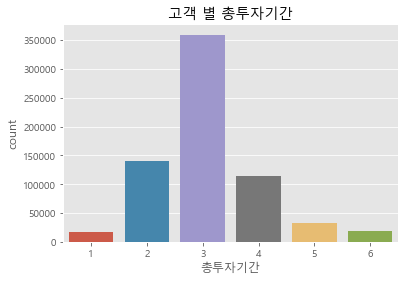

In [83]:
sns.countplot(x='총투자기간',data=train_data)
plt.title('고객 별 총투자기간')
plt.show()

In [384]:
train_data['총투자제곱']=train_data.총투자기간**2
test_data['총투자제곱']=test_data.총투자기간**2

주거래업종구분
- mean_encoding을 해도 될 것으로도 보인다..

In [385]:
mean=train_data['hold_d'].mean()
agg=train_data.groupby('주거래업종구분')['hold_d'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)

train_data['주거래업종구분_ME']=train_data['주거래업종구분'].map(smooth)
test_data['주거래업종구분_ME']=test_data['주거래업종구분'].map(smooth)

종목한글명 - 종목업종
- 종목업종 별 종목 중 가장 많은 종목에 투자를 하였는지를 확인하기 위해 mode를 이용하여 사용
#### train_data 와 업종_주종목을 merge 한다( key=종목업종). 그렇게 들어간 업종_주종목과 종목한글명이 같다면 1 아니면 0 이런식으로 열을 만듦

In [386]:
업종_주종목=train_test.groupby('종목업종')['종목한글명'].agg([('업종_주종목', lambda x: x.mode()[0])]).reset_index()

In [387]:
train_data=pd.merge(train_data, 업종_주종목, how='left', on='종목업종')
test_data=pd.merge(test_data, 업종_주종목, how='left', on='종목업종')

In [388]:
train_data.loc[train_data[(train_data["종목한글명"] == train_data["업종_주종목"])].index,'업종_주종목']=1
train_data['업종_주종목']=train_data.업종_주종목.apply(lambda x: x if x==1 else 0)

test_data.loc[test_data[(test_data["종목한글명"] == test_data["업종_주종목"])].index,'업종_주종목']=1
test_data['업종_주종목']=test_data.업종_주종목.apply(lambda x: x if x==1 else 0)

### word2vec

In [217]:
# 구매 정보 관련
train_data['투자_자산_wv'] = train_data['투자성향'].astype(str) + '_' + train_data['자산구간'].astype(str) 

test_data['투자_자산_wv'] = test_data['투자성향'].astype(str) + '_' + test_data['자산구간'].astype(str) 

In [229]:
import random

trn = list(train_data.groupby(['계좌번호','종목코드','매수일자'])['투자_자산_wv'].unique())
tst = list(test_data.groupby(['계좌번호','종목코드','매수일자'])['투자_자산_wv'].unique())

In [233]:
trn

[array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['4_2'], dtype=object),
 array(['2_4'], dtype=object),
 array(['2_4'], dtype=object),
 array(['2_4'], dtype=object),
 array(['2_4'], dtype=object),
 array(['2_4'], dtype=object),
 array(['2_4'], dtype=object),
 array(['2_4'], dtype=object),
 array(['2_4'], dtype=object),
 array(['2_4'], dtype=object),
 array([

In [234]:
def oversample(x, n,seed=0):
    lst = []
    for i in x:
        tmp = []
        np.random.seed(seed)
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [235]:
w2v_input = oversample(trn, 10)

In [236]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 100, window = 5, min_count = 1, sg = 1,seed=0)

KeyboardInterrupt: 

In [211]:
train_mean_vector = []
for words in tqdm(trn):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|███████████████████████████████████████████████████████████████████████████| 9337/9337 [00:00<00:00, 98243.01it/s]


In [212]:
test_mean_vector = []
for words in tqdm(tst):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|███████████████████████████████████████████████████████████████████████████| 9980/9980 [00:00<00:00, 96868.16it/s]


In [213]:
train_mean_vector = pd.DataFrame(train_mean_vector)
test_mean_vector = pd.DataFrame(test_mean_vector)

In [214]:
train_mean_vector.isnull().sum().sum(),test_mean_vector.isnull().sum().sum()

(0, 0)

In [216]:
train_mean_vector.shape,test_mean_vector.shape

((9337, 100), (9980, 100))

In [389]:
train_data = train_data.drop(["계좌번호", "종목코드", "매수일자", "기준일자"], axis = 1)
test_data = test_data.drop(["계좌번호", "종목코드", "매수일자", "submit_id", "hold_d", "기준일자",'과거보유일'], axis = 1)

In [390]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

In [391]:
L_encoder = LabelEncoder()
L_encoder.fit(iem["종목한글명"])
train_data["종목한글명"] = L_encoder.transform(train_data["종목한글명"])
test_data["종목한글명"] = L_encoder.transform(test_data["종목한글명"])

In [242]:
#a=pd.get_dummies(train_data['투자_자산_wv'])
#b=pd.get_dummies(test_data['투자_자산_wv'])

In [243]:
#a_sub_b = [x for x in a.columns if x not in b.columns]
#a.drop(a_sub_b,axis=1,inplace=True)

In [244]:
#b_sub_a = [x for x in b.columns if x not in a.columns]
#b.drop(b_sub_a,axis=1,inplace=True)

In [245]:
#train_data=pd.concat([train_data,a],axis=1)
#test_data=pd.concat([test_data,b],axis=1)

In [392]:
train_data.shape,test_data.shape

((681472, 34), (70596, 34))

In [393]:
train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

In [261]:
#train_data.drop(["투자_자산_wv"], axis = 1, inplace = True)
#test_data.drop(["투자_자산_wv"], axis = 1, inplace = True)

## Modeling

In [394]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(train_data):
    
    train_x = train_data.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_data.iloc[val_idx, :]
    val_y = train_label[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    models.append(model)

Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 62.7988	valid_0's l2: 3943.69
Early stopping, best iteration is:
[216]	valid_0's rmse: 62.6204	valid_0's l2: 3921.32
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 67.8086	valid_0's l2: 4598.01
Early stopping, best iteration is:
[447]	valid_0's rmse: 67.7878	valid_0's l2: 4595.18
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 71.2815	valid_0's l2: 5081.06
[1000]	valid_0's rmse: 71.143	valid_0's l2: 5061.32
[1500]	valid_0's rmse: 71.0995	valid_0's l2: 5055.14
Early stopping, best iteration is:
[1237]	valid_0's rmse: 71.0653	valid_0's l2: 5050.27
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 57.6106	valid_0's l2: 3318.98
[1000]	valid_0's rmse: 57.5456	valid_0's l2: 3311.5
[1500]	valid_0's rmse: 57.4726	valid_0's l2: 3303.1
[2000]	valid_0's rmse: 57.4625	valid_0's l2: 3301.94
Did not meet early s

In [395]:
pd.DataFrame(model.feature_importances_,index=train_data.columns).plot.bar()

In [396]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)

In [397]:
submission["hold_d"] = np.round(predict)

In [398]:
submission.to_csv("dacon_baseline.csv", index = False)

#### Bayesian Opt

In [262]:
ftr = train_data

In [263]:
target=train_label

In [264]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((477030, 60), (204442, 60))

In [265]:
from bayes_opt import BayesianOptimization

In [266]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [267]:
def lgb_rmse_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'RMSE', verbose= 100, 
                early_stopping_rounds= 100)
    valid_pred = lgb_model.predict(valid_x)
    RMSE = np.sqrt(mean_squared_error(valid_y, valid_pred))
    
    return RMSE

In [268]:
lgbBO = BayesianOptimization(f=lgb_rmse_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 12.018	training's l2: 144.433	valid_1's rmse: 11.92	valid_1's l2: 142.087
[200]	training's rmse: 3.19423	training's l2: 10.2031	valid_1's rmse: 2.75257	valid_1's l2: 7.57664
[300]	training's rmse: 1.98932	training's l2: 3.95738	valid_1's rmse: 1.30434	valid_1's l2: 1.70131
[400]	training's rmse: 1.79635	training's l2: 3.22686	valid_1's rmse: 1.08134	valid_1's l2: 1.16929
[500]	training's rmse: 1.71586	training's l2: 2.94417	valid_1's rmse: 1.02317	valid_1's l2: 1.04688
[600]	training's rmse: 1.67486	training's l2: 2.80516	valid_1's rmse: 0.983042	valid_1's l2: 0.966371
[700]	training's rmse: 1.6513	training's l2: 2.7268	valid_1's rmse: 0.9

[1100]	training's rmse: 1.71552	training's l2: 2.94301	valid_1's rmse: 1.03267	valid_1's l2: 1.06641
[1200]	training's rmse: 1.70763	training's l2: 2.91601	valid_1's rmse: 1.0308	valid_1's l2: 1.06255
[1300]	training's rmse: 1.70019	training's l2: 2.89063	valid_1's rmse: 1.02895	valid_1's l2: 1.05874
[1400]	training's rmse: 1.69244	training's l2: 2.86437	valid_1's rmse: 1.02893	valid_1's l2: 1.05869
Early stopping, best iteration is:
[1330]	training's rmse: 1.69849	training's l2: 2.88486	valid_1's rmse: 1.02823	valid_1's l2: 1.05727
|  5        |  1.028    |  0.806    |  312.3    |  15.55    |  139.5    |  18.62    |  41.48    |  34.88    |  0.6032   |  0.8334   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 16.7527	training's l2: 280.653	valid_1's rmse: 16.7385	valid_1's l2: 280.178
[200]	training's rmse: 4.96521	training's l2: 24.6534	valid_1's rmse: 4.66485	valid_1's l2: 21.7609
[300]	training's rmse: 2.73266	training's l2: 7.46741	valid_1's r

[200]	training's rmse: 3.85456	training's l2: 14.8577	valid_1's rmse: 3.44705	valid_1's l2: 11.8821
[300]	training's rmse: 2.35961	training's l2: 5.56776	valid_1's rmse: 1.70648	valid_1's l2: 2.91206
[400]	training's rmse: 2.1153	training's l2: 4.47451	valid_1's rmse: 1.41293	valid_1's l2: 1.99638
[500]	training's rmse: 2.02206	training's l2: 4.08874	valid_1's rmse: 1.30982	valid_1's l2: 1.71562
[600]	training's rmse: 1.96741	training's l2: 3.87069	valid_1's rmse: 1.25135	valid_1's l2: 1.56588
[700]	training's rmse: 1.93574	training's l2: 3.7471	valid_1's rmse: 1.21873	valid_1's l2: 1.48531
[800]	training's rmse: 1.90992	training's l2: 3.64781	valid_1's rmse: 1.1964	valid_1's l2: 1.43136
[900]	training's rmse: 1.89034	training's l2: 3.57338	valid_1's rmse: 1.18169	valid_1's l2: 1.39638
[1000]	training's rmse: 1.87428	training's l2: 3.51291	valid_1's rmse: 1.1698	valid_1's l2: 1.36844
[1100]	training's rmse: 1.8625	training's l2: 3.4689	valid_1's rmse: 1.16064	valid_1's l2: 1.34708
[120

[1700]	training's rmse: 1.8749	training's l2: 3.51526	valid_1's rmse: 1.27063	valid_1's l2: 1.6145
[1800]	training's rmse: 1.86284	training's l2: 3.47019	valid_1's rmse: 1.26259	valid_1's l2: 1.59413
[1900]	training's rmse: 1.85235	training's l2: 3.4312	valid_1's rmse: 1.25597	valid_1's l2: 1.57747
[2000]	training's rmse: 1.84213	training's l2: 3.39345	valid_1's rmse: 1.25065	valid_1's l2: 1.56413
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 1.84213	training's l2: 3.39345	valid_1's rmse: 1.25065	valid_1's l2: 1.56413
|  12       |  1.251    |  0.5      |  440.0    |  9.872    |  188.9    |  14.49    |  63.9     |  9.861    |  10.0     |  0.5      |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 10.9324	training's l2: 119.518	valid_1's rmse: 10.8125	valid_1's l2: 116.91
[200]	training's rmse: 2.76633	training's l2: 7.65259	valid_1's rmse: 2.42179	valid_1's l2: 5.86505
[300]	training's rmse: 1.63743	training's l2: 2.68117	v

|  16       |  1.067    |  0.7405   |  120.1    |  12.94    |  53.76    |  42.68    |  47.66    |  10.66    |  1.986    |  0.8184   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 16.8908	training's l2: 285.301	valid_1's rmse: 16.9083	valid_1's l2: 285.891
[200]	training's rmse: 6.34501	training's l2: 40.2591	valid_1's rmse: 6.17211	valid_1's l2: 38.0949
[300]	training's rmse: 3.14998	training's l2: 9.92237	valid_1's rmse: 2.78334	valid_1's l2: 7.74697
[400]	training's rmse: 2.27796	training's l2: 5.18912	valid_1's rmse: 1.79265	valid_1's l2: 3.2136
[500]	training's rmse: 1.99118	training's l2: 3.9648	valid_1's rmse: 1.45787	valid_1's l2: 2.12539
[600]	training's rmse: 1.85497	training's l2: 3.44091	valid_1's rmse: 1.30732	valid_1's l2: 1.70907
[700]	training's rmse: 1.76828	training's l2: 3.12683	valid_1's rmse: 1.22284	valid_1's l2: 1.49535
[800]	training's rmse: 1.71477	training's l2: 2.94043	valid_1's rmse: 1.17344	valid_1's l2: 1.37695
[900]	

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 16.1678	training's l2: 261.397	valid_1's rmse: 16.1384	valid_1's l2: 260.449
[200]	training's rmse: 4.72622	training's l2: 22.3371	valid_1's rmse: 4.42065	valid_1's l2: 19.5421
[300]	training's rmse: 2.48286	training's l2: 6.1646	valid_1's rmse: 1.94735	valid_1's l2: 3.79218
[400]	training's rmse: 2.04293	training's l2: 4.17354	valid_1's rmse: 1.4449	valid_1's l2: 2.08774
[500]	training's rmse: 1.87079	training's l2: 3.49985	valid_1's rmse: 1.25494	valid_1's l2: 1.57488
[600]	training's rmse: 1.78199	training's l2: 3.17549	valid_1's rmse: 1.17202	valid_1's l2: 1.37364
[700]	training's rmse: 1.7282	training's l2: 2.98669	valid_1's rmse: 1.1288	valid_1's l2: 1.2742
[800]	training's rmse: 1.69498	training's l2: 2.87295	valid_1's rmse: 1.09758	valid_1's l2: 1.20468
[900]	training's rmse: 1.67058	training's l2: 2.79083	valid_1's rmse: 1.07488	valid_1's l2: 1.15538
[1000]	training's rmse: 1.64836	training's 

[200]	training's rmse: 7.48049	training's l2: 55.9577	valid_1's rmse: 7.30272	valid_1's l2: 53.3297
[300]	training's rmse: 3.70213	training's l2: 13.7058	valid_1's rmse: 3.28369	valid_1's l2: 10.7826
[400]	training's rmse: 2.78613	training's l2: 7.76251	valid_1's rmse: 2.22962	valid_1's l2: 4.97122
[500]	training's rmse: 2.47455	training's l2: 6.12338	valid_1's rmse: 1.85533	valid_1's l2: 3.44226
[600]	training's rmse: 2.33256	training's l2: 5.44084	valid_1's rmse: 1.69152	valid_1's l2: 2.86125
[700]	training's rmse: 2.24467	training's l2: 5.03855	valid_1's rmse: 1.59549	valid_1's l2: 2.54559
[800]	training's rmse: 2.19002	training's l2: 4.79617	valid_1's rmse: 1.53675	valid_1's l2: 2.36159
[900]	training's rmse: 2.15278	training's l2: 4.63446	valid_1's rmse: 1.49529	valid_1's l2: 2.23588
[1000]	training's rmse: 2.12235	training's l2: 4.50435	valid_1's rmse: 1.46292	valid_1's l2: 2.14013
[1100]	training's rmse: 2.09422	training's l2: 4.38576	valid_1's rmse: 1.43258	valid_1's l2: 2.0522

[1100]	training's rmse: 2.09535	training's l2: 4.39051	valid_1's rmse: 1.42063	valid_1's l2: 2.0182
[1200]	training's rmse: 2.07203	training's l2: 4.29332	valid_1's rmse: 1.39539	valid_1's l2: 1.94712
[1300]	training's rmse: 2.04948	training's l2: 4.20039	valid_1's rmse: 1.37312	valid_1's l2: 1.88546
[1400]	training's rmse: 2.03165	training's l2: 4.12761	valid_1's rmse: 1.35664	valid_1's l2: 1.84048
[1500]	training's rmse: 2.01674	training's l2: 4.06723	valid_1's rmse: 1.34505	valid_1's l2: 1.80916
[1600]	training's rmse: 2.00124	training's l2: 4.00496	valid_1's rmse: 1.33358	valid_1's l2: 1.77844
[1700]	training's rmse: 1.98848	training's l2: 3.95404	valid_1's rmse: 1.32673	valid_1's l2: 1.76022
[1800]	training's rmse: 1.97674	training's l2: 3.90752	valid_1's rmse: 1.32134	valid_1's l2: 1.74593
[1900]	training's rmse: 1.96584	training's l2: 3.86454	valid_1's rmse: 1.31526	valid_1's l2: 1.7299
[2000]	training's rmse: 1.95535	training's l2: 3.8234	valid_1's rmse: 1.31041	valid_1's l2: 1

In [269]:
lgbBO.res

[{'target': 0.9161836673708834,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 0.9611643394160162,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 1.0095951856424543,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.6124

In [270]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmin(np.array(target_list)))

[0.9161836673708834, 0.9611643394160162, 1.0095951856424543, 0.9166972406402161, 1.0282347581873081, 1.1795221649596168, 1.2255910364161122, 1.2380606206964697, 1.130015544464695, 1.253852537738404, 0.9478855880552536, 1.2506507828736044, 1.048583825402263, 1.1371425604827516, 0.8724439760943207, 1.0668918846090056, 1.0474101450761488, 1.2585941641683374, 0.7740354711307526, 1.3100990519116082, 0.9994966803260473, 1.0198372799007125, 0.913403802008834, 0.8980131561767597, 1.3133171134826225, 1.3178398234203763, 1.2847877457379298, 1.3178398234203763, 1.3104133591290943, 1.2776502636614695]
maximum target index: 18


In [273]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(max_dict)

{'target': 0.7740354711307526, 'params': {'colsample_bytree': 0.9644030062523238, 'max_bin': 330.0928781095815, 'max_depth': 11.73763609663307, 'min_child_samples': 22.200684457930734, 'min_child_weight': 30.449321845606374, 'num_leaves': 42.41391927150943, 'reg_alpha': 41.1241425119106, 'reg_lambda': 7.101780863951866, 'subsample': 0.7549971229139905}}


In [274]:
ftr = train_data
target =  train_label

In [275]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):
    ftr = ftr
    target = target

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0],))  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros(((test_data.shape[0],)))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMRegressor(
                nthread=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=12,
                num_leaves=42,
                colsample_bytree=0.9644030062523238,
                subsample=0.7549971229139905,
                max_bin=330,
                reg_alpha=41.1241425119106,
                reg_lambda=7.101780863951866,
                min_child_weight=30.449321845606374,
                min_child_samples=22,
                silent=-1,
                verbose=-1,
                )


    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'RMSE', verbose= 200, 
                early_stopping_rounds= 200)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict(test_data, num_iteration=clf.best_iteration_)/folds.n_splits
        
        
    return clf, test_preds

In [276]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration  0  시작
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 7.75622	training's l2: 60.1589	valid_1's rmse: 7.59719	valid_1's l2: 57.7173
[400]	training's rmse: 1.56599	training's l2: 2.45232	valid_1's rmse: 1.23687	valid_1's l2: 1.52985
[600]	training's rmse: 1.044	training's l2: 1.08993	valid_1's rmse: 0.772974	valid_1's l2: 0.597489
Early stopping, best iteration is:
[582]	training's rmse: 1.05437	training's l2: 1.11169	valid_1's rmse: 0.77014	valid_1's l2: 0.593116
##### iteration  1  시작
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 7.74703	training's l2: 60.0164	valid_1's rmse: 7.71766	valid_1's l2: 59.5623
[400]	training's rmse: 1.51972	training's l2: 2.30954	valid_1's rmse

In [277]:
test_preds

array([255.06485511, 559.14334568, 232.04668006, ..., 856.53037582,
        18.95766583,   7.47416056])

In [77]:
test_preds

array([255.13542954, 559.55498699, 232.13264084, ..., 853.98756537,
        18.98660213,   7.44441985])

In [278]:
submission["hold_d"] = np.round(test_preds)

In [279]:
submission.to_csv("dacon_baseline_1.csv", index = False)